In [20]:
from datasets import load_dataset, Audio

dataset = load_dataset('parquet', data_files=['dataset_50.parquet'])['train']

In [21]:
import numpy as np
from huggingface_hub import hf_hub_download
from augment.noise import GaussianNoise, PerlinNoise
from augment.pca import PCAPerturbation
from svc_helper.svc.rvc import RVCModel
import torch
import random

rvc_model = RVCModel()
test_model_path = hf_hub_download(repo_id='therealvul/RVCv2', 
    filename='RarityS1/Rarity.pth')
test_index_path = hf_hub_download(repo_id='therealvul/RVCv2', 
    filename='RarityS1/added_IVF1866_Flat_nprobe_1_Rarity_v2.index')
rvc_model.load_model(model_path = test_model_path,
    index_path = test_index_path)

2024-07-24 17:00:56 | INFO | svc_helper.svc.rvc.modules.vc.modules | Get sid: D:\hf_cache\hub\models--therealvul--RVCv2\snapshots\87778762d011892db45370f0dd963be836d55a08\RarityS1\Rarity.pth
2024-07-24 17:00:56 | INFO | svc_helper.svc.rvc.modules.vc.modules | Loading: D:\hf_cache\hub\models--therealvul--RVCv2\snapshots\87778762d011892db45370f0dd963be836d55a08\RarityS1\Rarity.pth
c:\Users\vul\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
import librosa
import IPython.display as ipd
import numpy as np
audio = np.array(dataset[26]['audio']['array'])
resampled = librosa.resample(audio, orig_sr=48000, target_sr=16000)

gn = GaussianNoise(
    noise_scale_delegate = lambda: random.choice([1.0, 1.3, 1.6, 2.0])
)
pca = PCAPerturbation(
    apply_perturbations_delegate = lambda: [
        0,
        6 - random.random()*12.0,
        6 - random.random()*12.0,
        6 - random.random()*12.0
    ]
)
pn = PerlinNoise(
    noise_scale_delegate = lambda: 1.0*random.choice([1.0, 1.3, 1.6, 2.0]),
    scale=0.3,
    inner_module = pca
)

def feature_transform(feats):
    #audio, feats, _ = pn.process_features(None,feats)
    #audio, feats, _ = gn.process_features(None,feats)
    audio, feats, _ = pca.process_features(None,feats)
    return feats

wav_opt = rvc_model.infer_audio(resampled, feature_transform=feature_transform,
    index_rate=1.0)
ipd.Audio(wav_opt, rate=rvc_model.output_sample_rate())

2024-07-24 12:35:02 | INFO | fairseq.tasks.hubert_pretraining | current directory is d:\Code\raraai\3_featuretestmamba
2024-07-24 12:35:02 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2024-07-24 12:35:02 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0

window 160
x_pad 3
audio_pad (180576,)
torch.Size([1, 180576])


c:\Users\vul\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [22]:
from svc_helper.sfeatures.models import RVCHubertModel
import torch
sfeatures_model = RVCHubertModel(device=torch.device('cuda'),
    is_half=True)

2024-07-24 17:00:59 | INFO | fairseq.tasks.hubert_pretraining | current directory is d:\Code\raraai\3_featuretestmamba
2024-07-24 17:00:59 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2024-07-24 17:01:00 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0

normalize: False


In [27]:
from model import FeatureDenoiser, LitFeatureDenoiser
checkpoint = './lightning_logs/version_9/checkpoints/epoch=29-step=14000.ckpt'
lmodel = LitFeatureDenoiser.load_from_checkpoint(
    checkpoint,
    config={
    'model': {
        'speech_emb_size': 768,
        'hidden_dim': 384,
        'dropout': 0.0,
        'n_layers': 6,
    },
},)
lmodel.eval()

import librosa
import IPython.display as ipd
import numpy as np
#audio = np.array(dataset[0]['audio']['array'])
#resampled = librosa.resample(audio, orig_sr=48000, target_sr=16000)
resampled, _ = librosa.load('ood3_male.flac', sr=16000)
#print(np.max(np.abs(resampled)))

gn = GaussianNoise(
    noise_scale_delegate = lambda: 0.3
)
pca = PCAPerturbation(
    apply_perturbations_delegate = lambda: [
        0, -0.2, 0.2, 0.1
    ]
)

import torch.nn as nn

print('Grabbing ref feats')
ref_feats = sfeatures_model.extract_features(
    audio=torch.from_numpy(resampled))
print(ref_feats)
print('Grabbing ref feats')

def feature_transform(feats):
    #audio, feats, _ = gn.process_features(None,feats)
    audio, feats, _ = pca.process_features(None,feats)
    feats = feats.float()
    orig_feats = feats
    print('feats shape: ',feats.shape)
    print('ref feats shape:',ref_feats.shape)
    #print('loss against ref',nn.functional.mse_loss(feats, ref_feats))
    with torch.no_grad():
        print(feats.mean(), feats.std())
        feats = lmodel.feature_denoiser(feats)
        print('mse loss',nn.functional.mse_loss(feats, orig_feats))
    return feats

def bias_transform(feats):
    feats += torch.ones_like(feats)*0.2
    return feats

print('Original')
ipd.display(ipd.Audio(resampled, rate=16000))
transpose=15
print('Unmodified')
wav_opt = rvc_model.infer_audio(resampled, index_rate=0.0, transpose=transpose)
ipd.display(ipd.Audio(wav_opt, rate=rvc_model.output_sample_rate()))
print('Index rate')
wav_opt = rvc_model.infer_audio(resampled, index_rate=1.0, transpose=transpose)
ipd.display(ipd.Audio(wav_opt, rate=rvc_model.output_sample_rate()))
#print('Bias')
#wav_opt = rvc_model.infer_audio(resampled, index_rate=0.0,
#    feature_transform=bias_transform, transpose=transpose)
#ipd.display(ipd.Audio(wav_opt, rate=rvc_model.output_sample_rate()))
print('My method')
wav_opt = rvc_model.infer_audio(resampled, index_rate=0.0,
    feature_transform=feature_transform, transpose=transpose)
ipd.display(ipd.Audio(wav_opt, rate=rvc_model.output_sample_rate()))

Grabbing ref feats
tensor([[[ 0.0440, -0.1556,  0.2104,  ..., -0.0436, -0.0958, -0.4180],
         [ 0.0444, -0.1534,  0.2235,  ..., -0.0446, -0.0770, -0.3928],
         [ 0.0174, -0.1530,  0.2236,  ..., -0.0591, -0.1406, -0.5015],
         ...,
         [ 0.0582, -0.1193, -0.1238,  ...,  0.1865, -0.0626, -0.0410],
         [ 0.0481, -0.0320, -0.1070,  ..., -0.0054, -0.0674, -0.3054],
         [ 0.0958, -0.0305, -0.0133,  ..., -0.0798, -0.1118, -0.3523]]],
       device='cuda:0', dtype=torch.float16)
Grabbing ref feats
Original


Unmodified


Index rate


My method
feats shape:  torch.Size([1, 412, 768])
ref feats shape: torch.Size([1, 112, 768])
tensor(-0.0064, device='cuda:0') tensor(0.3222, device='cuda:0')
mse loss tensor(0.0293, device='cuda:0')


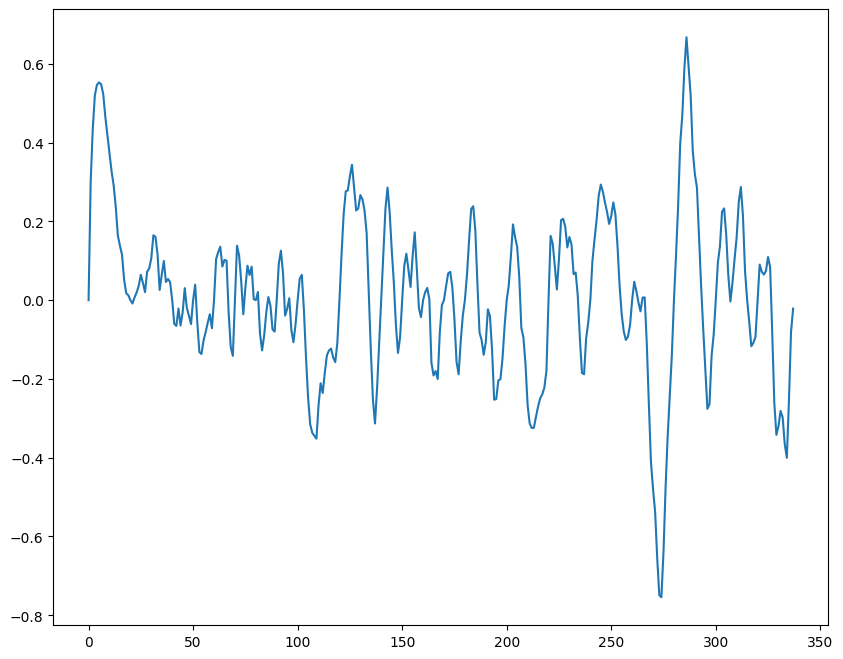

In [19]:
from noise import pnoise1
seq_len = 338
scale = 0.05
noise = np.zeros(seq_len)
for i in range(seq_len):
    noise[i] = pnoise1(i*scale, octaves=4)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(noise)
plt.show()